In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 11.1 그라디언트 소실과 폭주문제

- 활성화 함수 문제 : 로지스틱 함수는 입력의 절댓값이 커지면 0 또는 1로 수렴하게 되고 그렇게 되면 그레디언트가 0으로 된다. 그래서 역전파가 될 때 아래층으로 갈 수록 그레디언트가 전달 되지 않는다.
- 초기화 방식 : 각층에서 출력의 분산이 입력의 분산보다 커지면서 위쪽 층으로 갈 수록 분산이 계속 증가하게 되어 활성화 함수의 값이 0 or 1 수렴

#### 11.1.1 글로럿과 He 초기화
- 초기화 방식에서 $n_{in}$ 과 $n_{out}$ 같으면 분산이 동일하게 됨 (여기서 $n_{in}$은 입력 뉴런의 수, $n_{out}$은 출력 뉴런의 수)
- 만약 그렇지 않다면 각 층의 연결 가중치를 무작위로 초기화 함
- 글로럿 초기화
  - 균등 분포(Uniform distribution) : $W \sim U[-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}}]$
  - 정규 분포(Normal distribution) : $W \sim N(0, \frac{2}{n_{in}+n_{out}})$
  

| 초기화 방법                     | 분포                             | 설명                                                         |
| ------------------------------- | -------------------------------- | ------------------------------------------------------------ |
| 균등 분포(Uniform distribution) | $U[-\text{limit}, \text{limit}]$ | 무작위로 균등하게 초기화합니다. $\text{limit}$ 값은 $sqrt(\frac{6}{n_{in}+n_{out}})$과 같습니다. |
| 정규 분포(Normal distribution)  | $N(\mu, \sigma)$                 | 무작위로 정규 분포를 따르는 값으로 초기화합니다. $\mu$는 0이고, $\sigma$값은 $\sqrt{\frac{2}{n_{in}+n_{out}}}$과 같습니다. |
| 르쿤(Lecun) 초기화              | $N(0, \frac{1}{n_{in}})$         | ReLU나 SeLU와 같이 대칭이 아닌 활성화 함수를 사용할 때 적합합니다. |
| 글로럿(Glorot) 초기화           | $U[-\text{limit}, \text{limit}]$ | 하이퍼볼릭 탄젠트나 시그모이드와 같은 S자 모양의 활성화 함수를 사용할 때 적합합니다. $\text{limit}$ 값은 $sqrt(\frac{6}{n_{in}+n_{out}})$과 같습니다. |
| 해밍(Hamming) 초기화            | $U[-\text{limit}, \text{limit}]$ | 이진(binary) 분류 문제와 같이 범주형(categorical) 데이터셋에서 사용됩니다. |

In [2]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [3]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

#### 11.1.2 수렴하지 않는 활성화 함수
1. ReLU(Rectified Linear Unit) 함수 : 0이하의 값을 모두 0으로 출력 , 연산이 빠르지만 가중치의 합이 음수이면 기울기가 0이 되는 문제 발생
2. Leaky ReLU 함수 : 입력값이 0이하의 값일때 작은 양수 값을 유지 , 죽은 Relu문제 해결
3. ELU(Exponential Linear Unit) 함수 : 지수함수를 이용하여 그레디언트 소실 문제 해결 , 그러나 연산이 느림
4. SELU(Scaled Exponential Linear Unit) 함수 : 자기 정규화를 수행
5. ReLU의 변형 함수(PReLU, RReLU, LReLU)

In [5]:
(X_train_full,y_train_full) , (X_test,y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.
X_valid , X_train = X_train_full[:5000], X_train_full[5000:]
y_valid , y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape = [28,28]),
        keras.layers.Dense(300,kernel_initializer = "he_normal"),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(100,kernel_initializer = "he_normal"),
        keras.layers.LeakyReLU(alpha=0.2),
         keras.layers.Dense(10, activation="softmax")
    ]
)

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [9]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.3210 - accuracy: 0.6039 - val_loss: 0.8871 - val_accuracy: 0.7166
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7941 - accuracy: 0.7423 - val_loss: 0.7059 - val_accuracy: 0.7702
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6768 - accuracy: 0.7781 - val_loss: 0.6396 - val_accuracy: 0.7890
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.7973 - val_loss: 0.5841 - val_accuracy: 0.8100
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5789 - accuracy: 0.8080 - val_loss: 0.5534 - val_accuracy: 0.8162
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5519 - accuracy: 0.8153 - val_loss: 0.5313 - val_accuracy: 0.8246
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5314 - accuracy: 0.8200 - val_loss: 0.5128 - val_accuracy:

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [11]:
def selu(z, scale=1.05, alpha=1.67):
    return scale * elu(z, alpha)

그림 저장: selu_plot


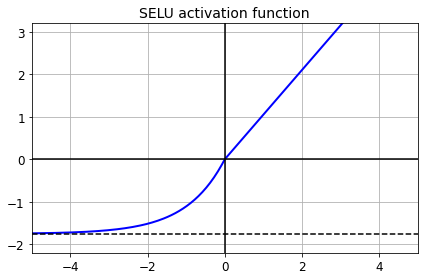

In [12]:
z = np.linspace(-5, 5, 200)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [13]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.95
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.90
Layer 400: mean 0.05, std deviation 0.87
Layer 500: mean -0.00, std deviation 0.92
Layer 600: mean 0.03, std deviation 0.91
Layer 700: mean -0.02, std deviation 0.89
Layer 800: mean 0.05, std deviation 0.81
Layer 900: mean 0.02, std deviation 0.99


#### 11.1.3 배치정규화
1. 미니배치에서 입력값의 평균과 분산을 계산합니다.
   - 입력값의 각 차원마다 평균과 분산을 계산합니다.
   - 이 때, 미니배치 내 모든 샘플에 대한 평균과 분산을 계산합니다.
   - 따라서, 평균과 분산을 계산하는 과정은 입력값의 각 차원마다 독립적으로 이루어집니다.
2. 평균과 분산을 사용하여 입력값을 정규화합니다.
   - 각 차원마다 정규화합니다.
   - 정규화된 입력값을 $\hat{x}$ 라고 합니다.
   - $\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$ (epsilon은 작은 값을 더해 분모가 0이 되는 것을 방지합니다)
3. 정규화된 입력값에 대해 스케일과 시프트를 적용합니다.
   - 학습 가능한 파라미터인 gamma와 beta를 사용합니다.
   - gamma는 스케일을, beta는 시프트를 나타냅니다.
   - 정규화된 입력값에 각각 gamma와 beta를 곱하고 더합니다.
   - 최종적으로, $y = \gamma \hat{x} + \beta$ 가 됩니다.
4. 정규화된 입력값에 스케일과 시프트를 적용한 결과를 활성화 함수로 전달합니다.
   - 활성화 함수로는 ReLU나 sigmoid 등을 사용할 수 있습니다.

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [17]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8534 - accuracy: 0.7122 - val_loss: 0.5551 - val_accuracy: 0.8090
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5755 - accuracy: 0.8008 - val_loss: 0.4750 - val_accuracy: 0.8382
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5177 - accuracy: 0.8184 - val_loss: 0.4407 - val_accuracy: 0.8468
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4795 - accuracy: 0.8327 - val_loss: 0.4159 - val_accuracy: 0.8548
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4535 - accuracy: 0.8408 - val_loss: 0.4007 - val_accuracy: 0.8600
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4370 - accuracy: 0.8461 - val_loss: 0.3879 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4229 - accuracy: 0.8527 - val_loss: 0.3771 - val_accuracy:

In [20]:
#활성화 함수 전에 배치 정규화 층을 추가하려면 은닉층에서 활성화 함수를 지정하지 말고 배치 정규화 층 뒤에 별도의 층으로 추가해야 함

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [22]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0371 - accuracy: 0.6753 - val_loss: 0.6654 - val_accuracy: 0.7864
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6736 - accuracy: 0.7789 - val_loss: 0.5486 - val_accuracy: 0.8214
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5944 - accuracy: 0.8010 - val_loss: 0.4959 - val_accuracy: 0.8366
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5427 - accuracy: 0.8171 - val_loss: 0.4632 - val_accuracy: 0.8444
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5106 - accuracy: 0.8264 - val_loss: 0.4415 - val_accuracy: 0.8506
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4890 - accuracy: 0.8315 - val_loss: 0.4238 - val_accuracy: 0.8516
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4707 - accuracy: 0.8382 - val_loss: 0.4116 - val_accuracy:

하이퍼파라미터 
- momentum : 지수이동평균에서 쓰이는 파라메터, 데이터셋이 크고 미니배치가 작으면 1에 더 가깝게 함
- axis : 마지막 축을 정규화 함

#### 11.1.4 그레이디언트 클리핑
- clipvalue or clipnorm 중에 지정하여 클리핑 할 수 있다.
- 일반적으로 배치 정규화면 충분함

### 11.2 사전훈련된 층 재사용하기

In [23]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [28]:
X_train_A.shape

(43986, 28, 28)

In [29]:
X_train_B.shape

(200, 28, 28)

In [30]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [31]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [32]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 2ms/step - loss: 0.5993 - accuracy: 0.8015 - val_loss: 0.3994 - val_accuracy: 0.8622
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3603 - accuracy: 0.8776 - val_loss: 0.3240 - val_accuracy: 0.8834
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3180 - accuracy: 0.8906 - val_loss: 0.2968 - val_accuracy: 0.8976
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2976 - accuracy: 0.8978 - val_loss: 0.2812 - val_accuracy: 0.9026
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2843 - accuracy: 0.9026 - val_loss: 0.2706 - val_accuracy: 0.9056
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2744 - accuracy: 0.9065 - val_loss: 0.2683 - val_accuracy: 0.9058
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2663 - accuracy: 0.9098 - val_loss: 0.2653 - val_accuracy:

In [33]:
model_A.save("my_model_A.h5")

In [34]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [35]:
#binary_crossentropy
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [36]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 25ms/step - loss: 0.8648 - accuracy: 0.5200 - val_loss: 0.7024 - val_accuracy: 0.5811
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6373 - accuracy: 0.6250 - val_loss: 0.5453 - val_accuracy: 0.7333
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4965 - accuracy: 0.7750 - val_loss: 0.4552 - val_accuracy: 0.8225
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4125 - accuracy: 0.8600 - val_loss: 0.3876 - val_accuracy: 0.8641
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3483 - accuracy: 0.8950 - val_loss: 0.3353 - val_accuracy: 0.9016
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2989 - accuracy: 0.9000 - val_loss: 0.2957 - val_accuracy: 0.9199
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2619 - accuracy: 0.9300 - val_loss: 0.2648 - val_accuracy: 0.9300
Epoch 8/20
7/7 [================

In [40]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [42]:
model_A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 300)               235500    
                                                                 
 dense_12 (Dense)            (None, 100)               30100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 8)                

In [41]:
model_B_on_A.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 300)               235500    
                                                                 
 dense_12 (Dense)            (None, 100)               30100     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 1)                

In [43]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [44]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))